# DR Binary CNN's On Train Subset

## Import the Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks, initializers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers, metrics

In [2]:
# upload csv files
# setting the dtype=str is to prevent an error that occurs later on if I don't

traindf=pd.read_csv("./diabetic-retinopathy-detection/Data/trainLabels.csv",dtype=str)
testdf=pd.read_csv("./diabetic-retinopathy-detection/Data/sampleSubmission.csv",dtype=str)

In [3]:
traindf.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


## Cleaning the Data

In [4]:
# creating a function that adds ".jpeg" to the image names
def append_ext(fn):
    return fn+".jpeg"

traindf["image"]=traindf["image"].apply(append_ext)
testdf["image"]=testdf["image"].apply(append_ext)

In [5]:
# checking to see if it worked
traindf.head()

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


### Change Target to Binary

In [6]:
traindf.level.replace({"2":"1", "3":"1", "4":"1"}, inplace=True)

In [7]:
# check work
traindf.level.value_counts()

0    25810
1     9316
Name: level, dtype: int64

In [8]:
# same thing as percentages
traindf.level.value_counts(normalize=True)

0    0.734783
1    0.265217
Name: level, dtype: float64

According to the training data, if one were to predict the majority class (not having DR), they would have a 73.5% accuracy score. A good goal would be to build a model that performs better than that dummy model. :)

## Model Process

Code is not run in order here.
* Variables are first assigned under the specific model name below located under the "Results" heading
* Then the code blocks under this heading are ran
* Then the graphs are plotted after each model

In [217]:
# image preprocessing
datagen=ImageDataGenerator(rescale=1./255.,
                           rotation_range=90,
                           zoom_range=0.2,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           shear_range=0.1,
                           horizontal_flip=True,
                           vertical_flip=True,
                           brightness_range=[0.75,1.5],
                           validation_split=0.2)

In [218]:
# training subset generator (subset=training)
train_sub_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="./diabetic-retinopathy-detection/Data/train_subset/", # data from smaller "subset" folder
x_col="image",
y_col="level",
subset="training",
batch_size=batches,
seed=42,
shuffle=True,
class_mode="binary",
target_size=size)


# validation subset generator (subset=validation)
valid_sub_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="./diabetic-retinopathy-detection/Data/train_subset/", # data from smaller "subset" folder
x_col="image",
y_col="level",
subset="validation",
batch_size=batches,
seed=42,
shuffle=True,
class_mode="binary",
target_size=size)

/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 30126 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 4000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 30126 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


These warnings occur because the csv file has more images than my subset folder I created with 5,000 images.

In [219]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation=activation, padding = 'same', input_shape=shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation=activation))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation=activation))


# model.add(Conv2D(64, (3, 3), activation=activation))
# model.add(Conv2D(64, (3, 3), activation=activation))
# model.add(Conv2D(64, (3, 3), activation=activation))
# model.add(MaxPooling2D((2, 2)))

In [220]:
model.add(Flatten())
model.add(Dense(64, activation = activation, kernel_initializer=initializers.HeUniform()))
model.add(Dense(1, activation='sigmoid'))

In [221]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_101 (Conv2D)         (None, 5, 5, 64)          18496     
                                                                 
 flatten_19 (Flatten)        (None, 1600)            

In [222]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [223]:
early_stop = callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=1e-4,
                                     verbose=1,
                                     mode='min',
                                     patience=7)

In [224]:
results = model.fit(train_sub_generator,
                    validation_data = valid_sub_generator,
                    steps_per_epoch = train_sub_generator.n//train_sub_generator.batch_size,
                    validation_steps = valid_sub_generator.n//valid_sub_generator.batch_size,
                    epochs=50,
                    callbacks=early_stop,
                    class_weight=class_weight)

Epoch 1/50
125/125 [==============================] - 347s 3s/step - loss: 0.6981 - accuracy: 0.7235 - val_loss: 0.6803 - val_accuracy: 0.7319
Epoch 2/50
125/125 [==============================] - 343s 3s/step - loss: 0.6987 - accuracy: 0.7220 - val_loss: 0.6813 - val_accuracy: 0.7308
Epoch 3/50
125/125 [==============================] - 343s 3s/step - loss: 0.6987 - accuracy: 0.7195 - val_loss: 0.6810 - val_accuracy: 0.7298
Epoch 4/50
125/125 [==============================] - 342s 3s/step - loss: 0.6980 - accuracy: 0.7253 - val_loss: 0.6811 - val_accuracy: 0.7258
Epoch 5/50
125/125 [==============================] - 342s 3s/step - loss: 0.6982 - accuracy: 0.7235 - val_loss: 0.6813 - val_accuracy: 0.7298
Epoch 6/50
125/125 [==============================] - 342s 3s/step - loss: 0.6983 - accuracy: 0.7228 - val_loss: 0.6806 - val_accuracy: 0.7329
Epoch 7/50
125/125 [==============================] - 342s 3s/step - loss: 0.6985 - accuracy: 0.7203 - val_loss: 0.6798 - val_accuracy: 0.7288

## Results

### Model 1

In [9]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"

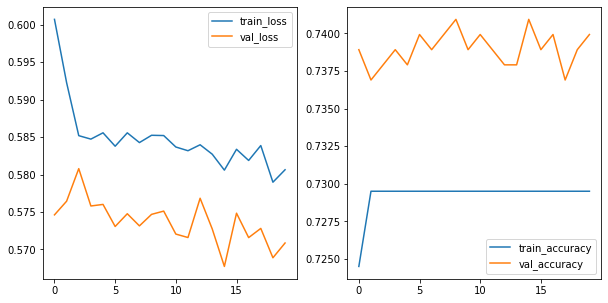

In [18]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Both the train loss and the validation loss have a steady decline. It's interesting to note that the validation data did better than the training data. And it did not take long for the train accuracy to plateau.

### Model 2

In [19]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (128,128)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"

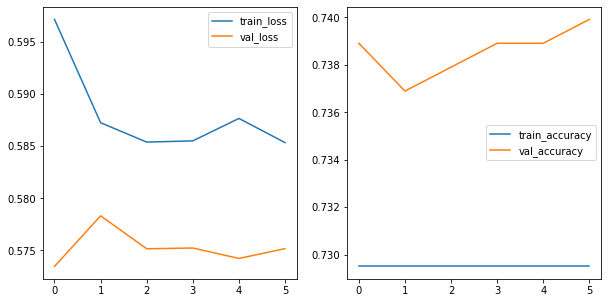

In [28]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

It looks like increasing the picture size did not decrease the loss or improve the accuracy significantly. There's a clearer picture of the validation loss decreasing with the smaller picture size. It's difficult to tell because it didn't run as many epochs. 

### Model 3

In [29]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "tanh"
optimizer = "adam"

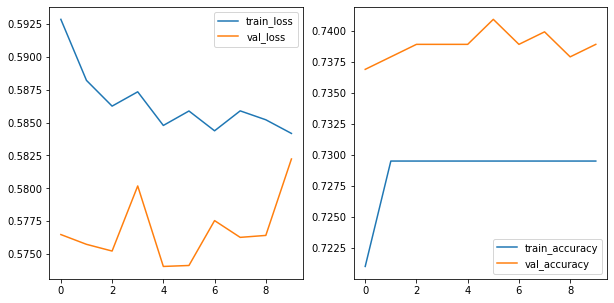

In [44]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

The tanh activation gave the validation loss very inconsistent results.

### Model 4

In [45]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "swish"
optimizer = "adam"

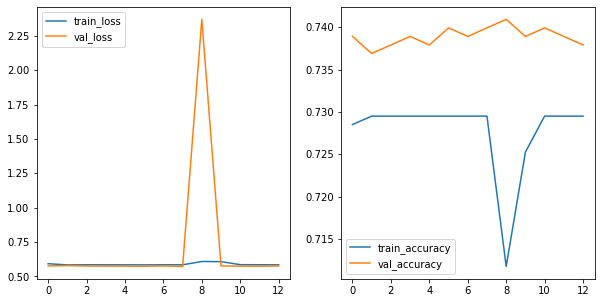

In [54]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

The swish activation gave a random spike, but mostly plateaued. 

### Model 5

In [55]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = ["relu","swish"]
optimizer = "adam"

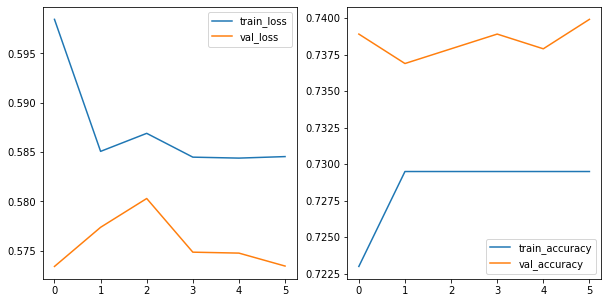

In [64]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

The combination of relu and swish activation functions did not seem to help much.  

### Model 6

In [65]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "RMSProp"

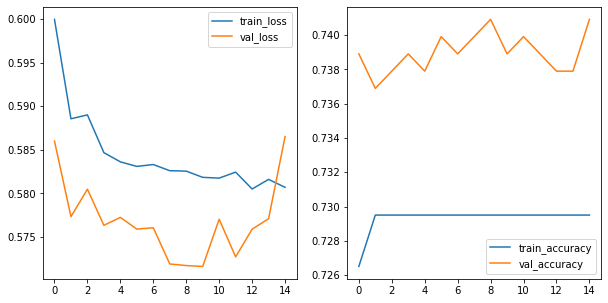

In [74]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 6
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Changing the optimizer to RMSProp looked pretty good until the end. The validation loss started to shoot up.

### Model 7

In [75]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 64 # changed from 32
activation = "relu"
optimizer = "adam"

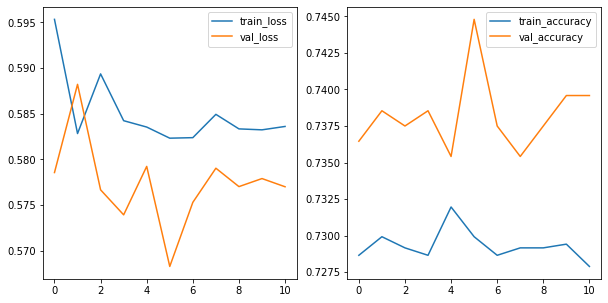

In [84]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 7
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Changing the batch size to 64 gave inconsistent results. 

### Model 8

In [85]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"
# remove dense layer

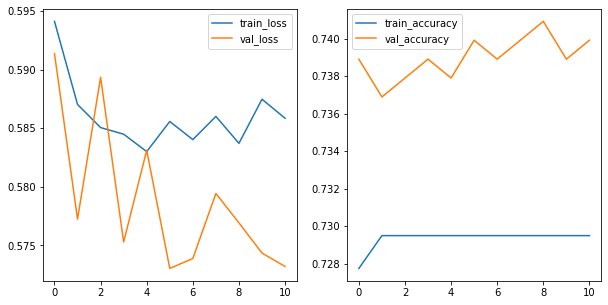

In [94]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 8
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Taking away a dense layer gave a general pattern of decline for the validation loss. I would prefer it to be smoother. 

### Model 9

In [95]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"
# additional dense layer

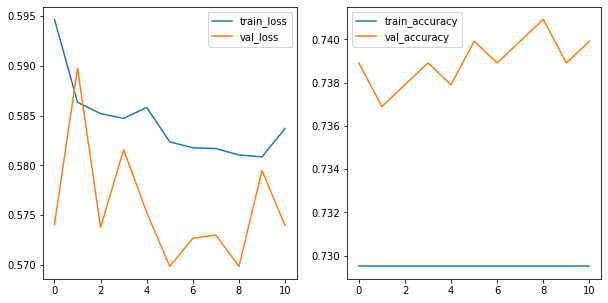

In [104]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 9
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Adding an additional dense layer did not help with the train accuracy plateau.

### Model 10

In [108]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.SGD(learning_rate=0.01)

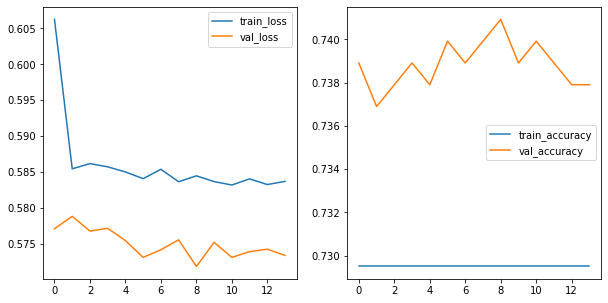

In [117]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

Changing optimizers to Stochastic Gradient Descent did not help much either. In order to break this plateau, I need to account for the class imbalance by implementing a class weight.

### Model 11

In [121]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"
# adding class weights

neg, pos = np.bincount(traindf.level)
total = neg + pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.89


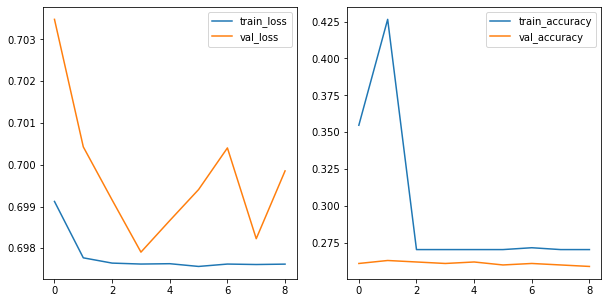

In [130]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 11
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

That changed some things. My average loss scores are very high and my accuracy scores are very low. But I can be confident that the model is guessing more than just the majority class. I want to try finding the right learning rate now.

### Model 12

In [157]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-5)
# with class weights

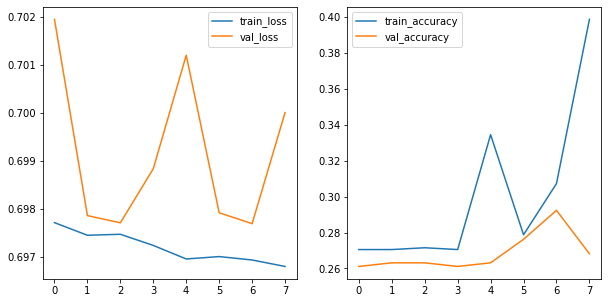

In [141]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 12
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

The validation loss seems to be inconsistent. I'm curious to see if increasing the patience level and adding more epochs would help. Let me try some other learning rates first.

### Model 13

In [142]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-4)
# with class weights

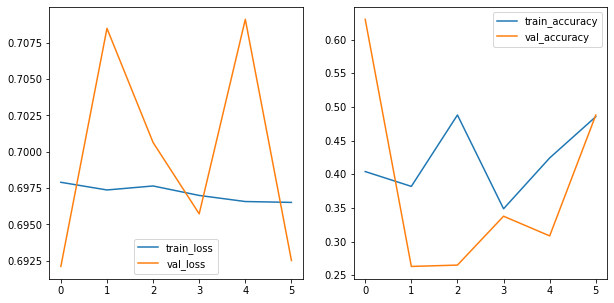

In [146]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 13
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

This one did not get very far at all. And the validation loss is very inconsistent.

### Model 14

In [147]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-3)
# with class weights

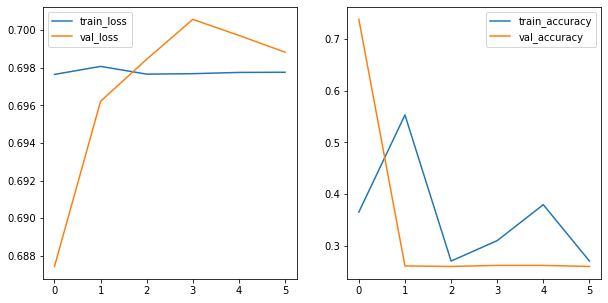

In [151]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

This one did not do well. The validation loss shot up instead of going down. And there weren't many epochs either. 

### Model 15

In [152]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-6)
# with class weights

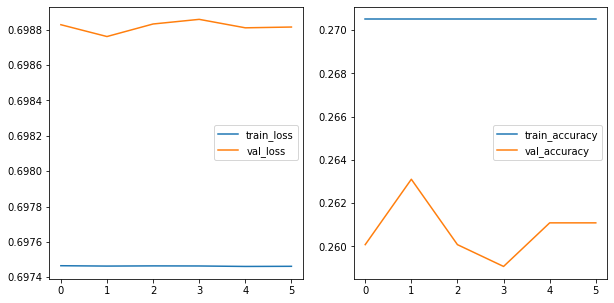

In [156]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 15
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

There aren't a whole lot of adjustments that were made on this one. I think the learning rate was a bit too slow.

### Model 16

In [ ]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-5)
# with class weights
# increasing patience level from 5 to 10 to get more epochs...

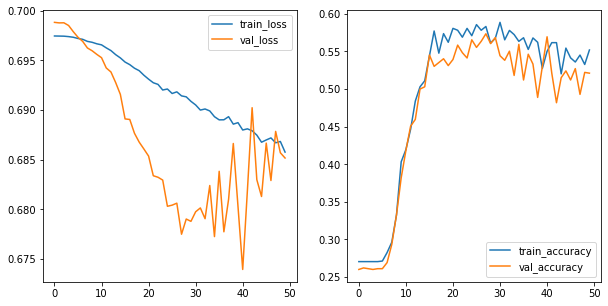

In [161]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 16
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

This is the first model that looks like something to work with. The losses go down and the accuracies go up. The accuracies aren't as high as I would like them. I'm going to try to simplify the model by removing some hidden layers. This might help to increase the accuracy score. 

### Model 17

In [168]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-6)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure by removing last 3 layers before flattening.
# adding featurewise_std_normalization to imagedatagenerator

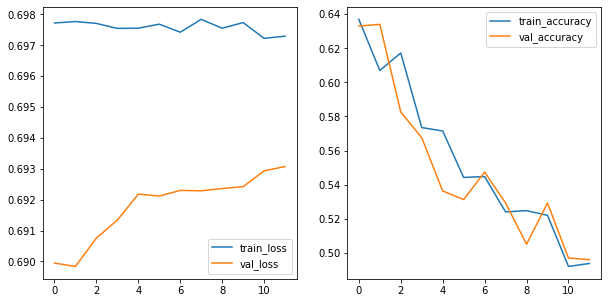

In [177]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 17
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

The accuracies are going down, which is not what I want to see. I may need to readjust my learning rate. But the accuracy scores are higher than the previous model.

### Model 18

In [191]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-5)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure completely alternating conv2d and maxpool total 5. 

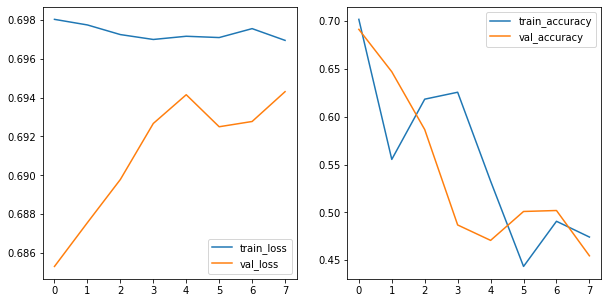

In [200]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 18
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Model 19

In [208]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-7)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure by removing last 3 layers before flattening.

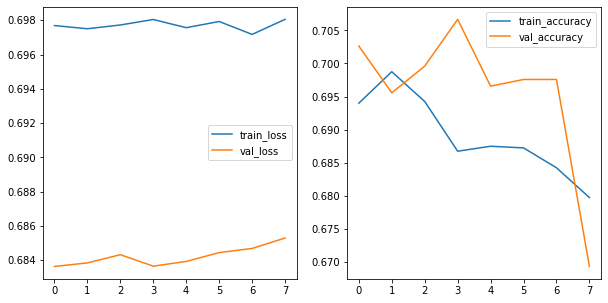

In [215]:
# create lists to plot
train_loss = results.history['loss']
train_acc = results.history['accuracy']
val_loss = results.history['val_loss']
val_acc = results.history['val_accuracy']

# the plot for model 19
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');

### Model 20

In [216]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-8)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure by removing last 3 layers before flattening.

In [233]:
def plot_results(fit_model):
    # create lists to plot
    train_loss = fit_model.history['loss']
    train_acc = fit_model.history['accuracy']
    val_loss = fit_model.history['val_loss']
    val_acc = fit_model.history['val_accuracy']
    
    # the plot for the fit_model
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');
    
    return None

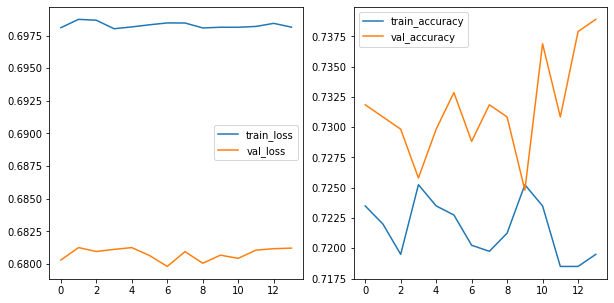

In [234]:
plot_results(results)

### Model 21

In [ ]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-4)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure by removing last 3 layers before flattening.

In [ ]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-8)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure by removing last 3 layers before flattening.

In [118]:
tf.keras.models.save_model(model, "half_binary_model.hdf5")

In [ ]:
neg, pos = np.bincount(traindf.level)
total = neg + pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))